# OpenAGI: When LLM Meet Domain Experts

#### Members' Names: Ishraqul Islam and Zain Ahmed

####  Emails: ishraqul.islam@torontomu.ca, 	zain2.ahmed@torontomu.ca

# Introduction:
Human Intelligence (HI) is highly proficient at integrating fundamental abilities to resolve intricate challenges. Embedding this feature in complete AI Agents is crucial for Artificial Intelligence (AI) as it allows them to utilize expert models to solve complicated tasks, ultimately leading to the development of Artificial General Intelligence (AGI). Large Language Models (LLMs) have impressive aptitude for learning and logical thinking, and can proficiently utilize external models, tools, plugins, or APIs to address intricate difficulties.


#### Problem Description:

This project introduces OpenAGI, a publicly available research platform for Artificial General Intelligence (AGI). OpenAGI is specifically designed to provide intricate, multi-step tasks together with task-specific datasets, assessment measures, and a wide variety of expandable models. OpenAGI converts intricate tasks into natural language queries, which are then used as input for the LLM. The LLM then chooses, combines, and carries out models offered by OpenAGI in order to tackle the assignment. In addition, the project introduces the Reinforcement Learning from Task Feedback (RLTF) mechanism, which utilizes the task-solving outcome as feedback to enhance the LLM's task-solving proficiency. The LLM is tasked with integrating diverse external models to address intricate challenges, while RLTF offers feedback to enhance its problem-solving capability, creating a feedback loop for self-improving artificial intelligence. We are confident that the concept of Language Learning Models (LLMs) utilizing many specialized models to solve difficult tasks is a highly promising approach towards achieving Artificial General Intelligence (AGI).

#### Solution:
LLM helps to generate text but with inclusion of OpenAGI makes it more understandable and solve multiproblem task.

# Methodology
This paper provided us with alot of method of how OpenAGI. Today here we are combining OpenAGI and RLTF.

LLM helps us to comprehend and understand human language text but with the introduction of OpenAGI, we can also interpret images too.

In this method, the users has a dataset full of images where it has few Task description involved.

While deriving the result there was benchmak tasks of OpenAGI comprise a diverse range of domain tasks. The performance was based on three metrics of CLIP Score, BERT Score and VIT Score.

To conduct RLTF the backbon LLM that we used here was Flan-T5-Large which is a series of language model fine tuned using a technique called instruction fine tuning and Flan T5 has 770 million parameters.

Figure: An illustration of RLTF mechanism
![](/content/FIg1.png)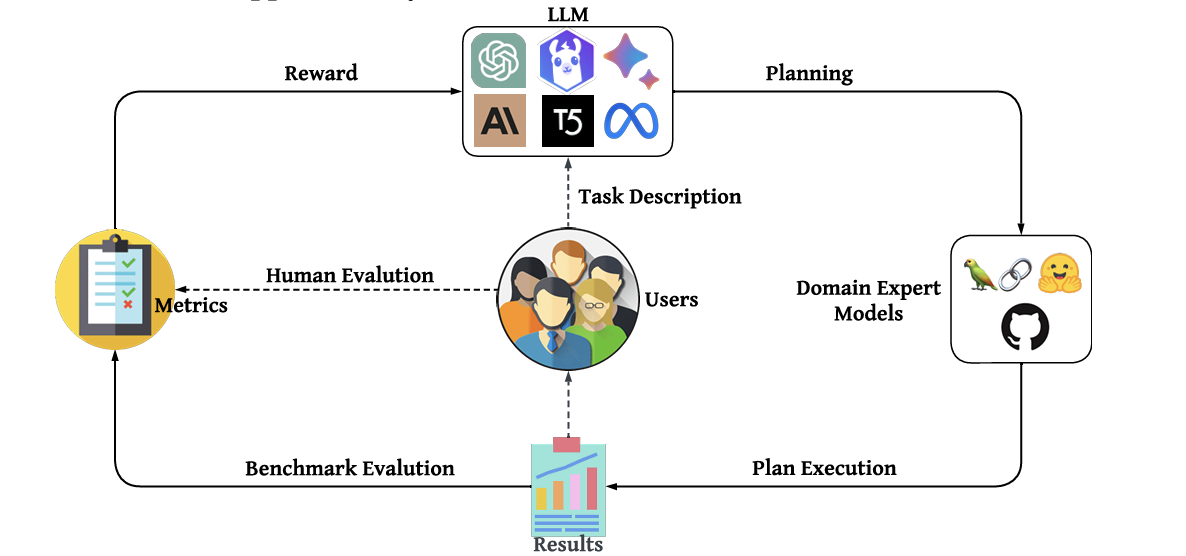


# Implementation

In this section, you will provide the code and its explanation. You may have to create more cells after this. (To keep the Notebook clean, do not display debugging output or thousands of print statements from hundreds of epochs. Make sure it is readable for others by reviewing it yourself carefully.)

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
from torch.utils.data import DataLoader
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
)
import os
os.chdir('../')
from generate_model_seq import SeqGen
import torch.optim as optim
from general_dataset import GeneralDataset
from agi_utils import *
from combine_model_seq import SeqCombine

In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--model_name", type=str, default="google/flan-t5-large")
parser.add_argument("--epochs", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=5)
parser.add_argument("--num_seq", type=int, default=1)
parser.add_argument("--learning_rate", type=float, default=1e-5)
parser.add_argument("--epsilon", type=float, default=0.2)
parser.add_argument("--decay_rate", type=float, default=0.9)
parser.add_argument("--weight_decay", type=float, default=1e-6)
parser.add_argument("--accumulate_steps", type=int, default=1)
parser.add_argument("--warm_up_proportion", type=float, default=0.1)

args = parser.parse_args("")

In [ ]:
"""
load training and test datasets
"""
data_path = "./openagi_data/"

task_discriptions = txt_loader("./task_description.txt")
training_task_idx = [7,20,30,40,50,60]
test_task_idx = [2,3,10,15,20,35,45,55,65,70,70,90,106,107]
training_dataloaders = []
test_dataloaders = []

for i in training_task_idx:
    dataset = GeneralDataset(i, data_path)
    dataloader = DataLoader(dataset, batch_size=args.batch_size)
    training_dataloaders.append(dataloader)

for j in test_task_idx:
    dataset = GeneralDataset(j,data_path)
    dataloader = DataLoader(dataset, batch_size=args.batch_size)
    test_dataloaders.append(dataloader)

training_tasks = [task_discriptions[i].strip() for i in training_task_idx]
test_tasks = [task_discriptions[j].strip() for j in test_task_idx]
# print(training_tasks)

In [ ]:
import numpy as np
from IPython.utils import io
import random
from tqdm import tqdm
from evaluate import load
from torchvision import transforms
from transformers import AutoModel, AutoFeatureExtractor
from torchmetrics.multimodal import CLIPScore

clip_score = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")


# Load a pre-trained Vision Transformer model and its feature extractor
vit_ckpt = "nateraw/vit-base-beans"
vit = AutoModel.from_pretrained(vit_ckpt)
vit.eval()
vit_extractor = AutoFeatureExtractor.from_pretrained(vit_ckpt)

f = transforms.ToPILImage()
bertscore = load("bertscore")

device_list = ["cuda:3","cpu"]
seqCombination = SeqCombine(device_list)

Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
from undecorated import undecorated
from finetune.utils import construct_optimizer
from types import MethodType

device = 'cpu'

tokenizer = T5Tokenizer.from_pretrained(args.model_name)
backbone_model = T5ForConditionalGeneration.from_pretrained(args.model_name).to(device)
backbone_model.load_state_dict(torch.load("./finetune/10_shot_finetuned.pt", map_location="cpu"))
backbone_model = backbone_model.to(device)

seqGen = SeqGen(backbone_model, tokenizer, device)

generate_with_grad = undecorated(seqGen.model.generate)
seqGen.model.generate_with_grad = MethodType(generate_with_grad, seqGen.model)
# optimizer = optim.SGD(seqGen.model.parameters(), lr=0.0001, momentum=0.9)
optimizer, scheduler = construct_optimizer(args, seqGen.model, 20)

### Training

In [ ]:
epochs = args.epochs
epsilon = args.epsilon
decay_rate = args.decay_rate


for e in range(epochs):
    baseline = 0
    rewards = []

    print('num of epoch ' + str(e+1))
    for i, task_description in enumerate(training_tasks):
        task_rewards = []
        # print(task_description)
        optimizer.zero_grad()
        generated_module_seq, log_prob = seqGen.generate_sequence([training_tasks[i]],\
                                                                   module_length=10, \
                                                                   beam_size=30, \
                                                                   num_seq=30,\
                                                                   top_k=5,\
                                                                   top_p=0.5,\
                                                                   temperature=0.9,\
                                                                   constraint=[0,100],\
                                                                   num_beam_groups=1)

        if random.random() >= epsilon:
            action = torch.argmax(torch.stack(log_prob).detach())
        else:
            action = torch.distributions.Categorical(torch.stack(log_prob).detach()).sample()

        # decrease epsilon by the decay rate after each step
        epsilon *= decay_rate

        module_list = generated_module_seq[action][:-1]

        if module_seq_filter(module_list, training_task_idx[i]):

            # print("Module Sequence: " + module_list)
            seqCombination.construct_module_seq(module_list)


            for idx, batch in enumerate(tqdm(training_dataloaders[i])):
                inputs = list(batch['input'][0])
                seqCombination.construct_module_seq(module_list)
                predictions = seqCombination.run_module_seq(inputs)

                if 0<=training_task_idx[i]<=14:
                    outputs = list(batch['output'][0])
                    dist = image_similarity(predictions, outputs, vit, vit_extractor)
                    task_rewards.append(dist/100)
                elif 15<=training_task_idx[i]<=104 or 107<=task_idx[i]<=184:
                    outputs = list(batch['output'][0])
                    f1 = np.mean(txt_eval(predictions, outputs, bertscore, device="cuda:4"))
                    task_rewards.append(f1)
                else:
                    clip_score = score = clip_score(predictions, inputs)
                    task_rewards.append(clip_score.detach()/100)
            ave_task_reward = np.mean(task_rewards)
            # print("Average reward on current task: " + str(ave_task_reward))
            rewards.append(ave_task_reward)

            seqCombination.close_module_seq()
        else:
            rewards.append(-1)

        avg_reward = np.mean(rewards)
        print("Average reward: " + str(avg_reward))
        loss = -log_prob[action] * (avg_reward - baseline)
        print("Loss: "+ str(loss.item()))
        loss.backward()
        optimizer.step()
        scheduler.step()
        # baseline = avg_reward

print("Finished training!")

num of epoch 1
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.42208486795425415
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.318587988615036
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Module Sequence: Image Deblurring, Colorization, Image Captioning, Machine Translation


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.56s/it]


Average reward on current task: 0.5220931270718575
Average reward: 0.0924639615416527
Loss: 0.07375849038362503
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.18065202884376047
Loss: -0.17308112978935242
Given noisy grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.3445216230750084
Loss: -0.19700469076633453
Given grayscale image, how to return the caption in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.4537680192291737
Loss: -0.15819662809371948
num of epoch 2
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.0759681910276413
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection, Machine Translation


100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Average reward on current task: 0.4525067138671875
Average reward: 0.6039027357101441
Loss: 2.6616015434265137
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: 0.06926849047342938
Loss: 0.016598308458924294
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.19804863214492796
Loss: -0.15320703387260437
Given noisy grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.3584389057159424
Loss: -0.3756587505340576
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


Average reward on current task: 0.7472007423639299
Average reward: -0.1741656310359637
Loss: -0.10421266406774521
num of epoch 3
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.022511431947350502
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.032507020980119705
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.4149004141489665
Loss: -0.0548413060605526
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Image Classification


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


Average reward on current task: 0.6491858996450901
Average reward: -0.14887883570045235
Loss: -0.09420302510261536
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


Average reward on current task: 0.4922473135590553
Average reward: -0.020653605848550815
Loss: -0.014669551514089108
Given grayscale image, how to return the caption in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.18387800487379236
Loss: -0.18939577043056488
num of epoch 4
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.015929579734802246
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.02616194263100624
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.4149004141489665
Loss: -0.08108014613389969
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Image Classification


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.70it/s]


Average reward on current task: 0.6491858996450901
Average reward: -0.14887883570045235
Loss: -0.1413099467754364
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]


Average reward on current task: 0.4922473135590553
Average reward: -0.020653605848550815
Loss: -0.016042789444327354
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.10732211885352931
Loss: 0.0799020454287529
num of epoch 5
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.013653181493282318
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.03281329199671745
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.4149004141489665
Loss: -0.2121475487947464
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Object Detection


100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.26it/s]


Average reward on current task: 0.2525896982848644
Average reward: -0.2480278860405088
Loss: -0.18281228840351105
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


Average reward on current task: 0.4922473135590553
Average reward: -0.09997284612059597
Loss: -0.08918529003858566
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.02it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.04122275196015834
Loss: 0.011298013851046562
num of epoch 6
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.012700541876256466
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.04361914470791817
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]


Average reward on current task: 0.7427397590875626
Average reward: 0.1660128388802211
Loss: 0.08189903199672699
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Object Detection


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.01it/s]


Average reward on current task: 0.2525896982848644
Average reward: 0.18765705373138192
Loss: 0.1406380981206894
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


Average reward on current task: 0.4922473135590553
Average reward: 0.2485751056969166
Loss: 0.25615283846855164
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.86it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.3316793784747521
Loss: 0.0672074630856514
num of epoch 7
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.012115244753658772
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.0494220033288002
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.14it/s]


Average reward on current task: 0.7427397590875626
Average reward: 0.1660128388802211
Loss: 0.04981960728764534
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Object Detection


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]


Average reward on current task: 0.2525896982848644
Average reward: 0.18765705373138192
Loss: 0.13459397852420807
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


Average reward on current task: 0.4922473135590553
Average reward: 0.2485751056969166
Loss: 0.25093725323677063
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.04it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.3316793784747521
Loss: 0.06142611429095268
num of epoch 8
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.15s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.011923258192837238
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.05006684362888336
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Average reward on current task: 0.7427397590875626
Average reward: 0.1660128388802211
Loss: 0.04802076146006584
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Object Detection


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.01it/s]


Average reward on current task: 0.2525896982848644
Average reward: 0.18765705373138192
Loss: 0.13415592908859253
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.08s/it]


Average reward on current task: 0.4922473135590553
Average reward: 0.2485751056969166
Loss: 0.25093725323677063
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.3316793784747521
Loss: 0.06142611429095268
num of epoch 9
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:22<00:00,  1.11s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.011923258192837238
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.05006684362888336
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Average reward on current task: 0.7427397590875626
Average reward: 0.1660128388802211
Loss: 0.04802076146006584
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Object Detection


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.19it/s]


Average reward on current task: 0.2525896982848644
Average reward: 0.18765705373138192
Loss: 0.13415592908859253
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.04s/it]


Average reward on current task: 0.4922473135590553
Average reward: 0.2485751056969166
Loss: 0.25093725323677063
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.07it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.3316793784747521
Loss: 0.06142611429095268
num of epoch 10
Given grayscale image, how to return the regular image step by step?
Module Sequence: Image Denoising


100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]


Average reward on current task: 0.7552987575531006
Average reward: 0.7552987575531006
Loss: 0.011923258192837238
Given low-resolutioned noisy blurry grayscale image, how to return the object names in English step by step?
Type not match.
Averaged reward on current task: -1
Average reward: -0.1223506212234497
Loss: -0.05006684362888336
Given low-resolutioned blurry grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.00it/s]


Average reward on current task: 0.7427397590875626
Average reward: 0.1660128388802211
Loss: 0.04802076146006584
Given low-resolutioned noisy grayscale image, how to return the class label in German step by step?
Module Sequence: Object Detection


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]


Average reward on current task: 0.2525896982848644
Average reward: 0.18765705373138192
Loss: 0.13415592908859253
Given noisy grayscale image, how to return the object names in English step by step?
Module Sequence: Image Deblurring, Object Detection


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


Average reward on current task: 0.4922473135590553
Average reward: 0.2485751056969166
Loss: 0.25093725323677063
Given grayscale image, how to return the caption in English step by step?
Module Sequence: Image Captioning


100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.08it/s]


Average reward on current task: 0.7472007423639299
Average reward: 0.3316793784747521
Loss: 0.06142611429095268
Finished training!


### Test

In [ ]:
rewards = []
clips = []
berts = []
similairies = []

for i, task_description in enumerate(test_tasks):
    task_rewards = []
    with torch.no_grad():
        generated_module_seq, log_prob = seqGen.generate_sequence([test_tasks[i]],\
                                                                   module_length=10, \
                                                                   beam_size=30, \
                                                                   num_seq=30,\
                                                                   top_k=5,\
                                                                   top_p=0.5,\
                                                                   temperature=0.9,\
                                                                   constraint=[0,100],\
                                                                   num_beam_groups=1)

    action = torch.argmax(torch.stack(log_prob).detach())


    module_list = generated_module_seq[action][:-1]
    # print(task_description)
    # print("Module Sequence: " + module_list)

    if module_seq_filter(module_list, test_task_idx[i]):
        seqCombination.construct_module_seq(module_list)

        for idx, batch in enumerate(tqdm(test_dataloaders[i])):
            inputs = list(batch['input'][0])
            predictions = seqCombination.run_module_seq(inputs)

            if 0<=test_task_idx[i]<=14:
                outputs = list(batch['output'][0])
                dist = image_similarity(predictions, outputs, vit, vit_extractor)
                task_rewards.append(dist/100)
            elif 15<=test_task_idx[i]<=104 or 107<=test_task_idx[i]:
                outputs = list(batch['output'][0])
                f1 = np.mean(txt_eval(predictions, outputs, bertscore))

                task_rewards.append(f1)
            else:
                score = clip_score(predictions, inputs)
                task_rewards.append(score.detach()/100)

        ave_task_reward = np.mean(task_rewards)


        seqCombination.close_module_seq()

    else:
        ave_task_reward = 0

    if 0<=test_task_idx[i]<=14:
        similairies.append(ave_task_reward)
    elif 15<=test_task_idx[i]<=104 or 107<=test_task_idx[i]<=184:
        berts.append(ave_task_reward)
    else:
        clips.append(ave_task_reward)

    rewards.append(ave_task_reward)


print("Finished testing!")

In [ ]:
np.mean(clips), np.mean(berts), np.mean(similairies), np.mean(rewards)

(0.30801663, 0.36068388568030463, 0.6245344698870623, 0.4134613496065139)

# Conclusion and Future Direction

With this project we learned a lot of things in the world of OpenAGI and LLM. This paper significantly introduced us to the various LLM model and its procedure of how to make a program executeable. In our project we just focused on the RLTF method known as the Reinforcement Learning From Task Feedback.

For future we can also implement Zero Shot, Few Shot Learning and Finetuning for future purposes if we want to expand our horizon. Also, we can use other LLM model like GPT, Claude, BERT to compare the result with our proposed methodology.

# References:

[1]:  Ge, Y., Tan, J., Hua, W., Xu, S., Mei, K., Li, Z., Ji, J., & Zhang, Y. (2023). OpenAGI: When LLM meet Domain Expert. Neura IPS.

